# Using AWS Lambda and PyWren for Landsat 8 Time Series
This notebook is a simple demonstration of drilling a timeseries of NDVI values from the [Landsat 8 scenes held on AWS](https://landsatonaws.com/)  
[Peter Scarth](mailto:p.scarth@uq.edu.au?subject=AWS%20Lambda%20and%20PyWren) (Joint Remote Sensing Research Program)

  
It relies on the l8_ndvi_point function from the [remotepixel-api](https://github.com/RemotePixel/remotepixel-api)  
It's recommended that you install this yourself, but currently a version of the API is accepting requests at the URL in the code below. Each call to the l8_ndvi_point function takes around 700ms using a 1536MB allocation thus costing about $0.00002 per call. It works by sending a request to an endpoint with a sceneID and a location like this:  
[https://w5xm4e5886.execute-api.us-west-2.amazonaws.com/production/l8_ndvi_point?coords=147.9,-28.7&scene=LC80920802015065LGN00](https://w5xm4e5886.execute-api.us-west-2.amazonaws.com/production/l8_ndvi_point?coords=147.9,-28.7&scene=LC80920802015065LGN00)  
This will return:  
`{"ndvi": 0.30603131651878357, "date": "2015-03-06", "cloud": 0.01}`

I initially wanted to call the API using grequests, but had a number of failures (I probably should have tried [request-threads](https://github.com/requests/requests-threads)), so I though why not call the lambda functions from lambda functions.  
  
  [PyWren](https://github.com/pywren/pywren) makes this super easy, although it's a bit of a waste of it's processing superpowers for this simple experiment. Where [PyWren](https://github.com/pywren/pywren) would become very useful is where you want to do processing on, say, entire Landsat bands using the l8_full function from the [remotepixel-api](https://github.com/RemotePixel/remotepixel-api).

Once we have the results back as a list of dictionaries, usually in under a minute for the full timeseries of more than 100 images, we can simply plot the resulting timeseries or do further analysis. BUT, the points may well be cloud or cloud shadow contaminated. We haven’t done any cloud masking to the imagery, but we do have the scene metadata on the probable amount of cloud across the entire scene. We use this to weight a [smoothing spline](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.UnivariateSpline.html), such that an observation with no reported cloud over the scene has full weight, and an observation with a reported 100% of the scene with cloud has zero weight.  
  
  ### Setup the functions to call the APIs


In [1]:
import requests, json, numpy, datetime
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pywren

# Function to return a Landsat 8 scene list given a Longitude,Latitude string
# This uses the amazing developmentseed Satellite API
# https://github.com/sat-utils/sat-api
def getSceneList(lonLat):
    scenes=[]
    url = "https://api.developmentseed.org/satellites/landsat"
    params = dict(
        contains=lonLat,
        satellite_name="landsat-8",
        limit="1000") 
    # Call the API to grab the scene metadata
    sceneMetaData = json.loads(requests.get(url=url, params=params).content)
    # Parse the metadata
    for record in sceneMetaData["results"]:
        scene = str(record['aws_index'].split('/')[-2]) 
        # This horrible hack is to get around some versioning problem on the API :(
        # I'd love to get this sorted out, probaby by hosting my own sat-api instance
        # Related to this issue https://github.com/sat-utils/sat-api/issues/18 
        if scene[-2:] == '01':
            scene = scene[:-2] + '00'
        if scene[-2:] == '02':
            scene = scene[:-2] + '00'
        if scene[-2:] == '03':
            scene = scene[:-2] + '02'
        scenes.append(scene)   
    return scenes


# Function to call a AWS Lambda function to drill a single pixel and compute the NDVI
# Replace the url here with the endpoint of your local function :)
def getNDVI(scene):
    url = " https://w5xm4e5886.execute-api.us-west-2.amazonaws.com/production/l8_ndvi_point"
    params = dict(
        coords=lonLat,
        scene=scene)
    # Call the API and return the JSON results
    resp = requests.get(url=url, params=params)
    return json.loads(resp.text)


### Run the code over a point of interest
This test site is a cotton farming area in Queensland, Australia [147.870599,-28.744617](https://goo.gl/maps/GF5szf7vZo82)

CPU times: user 11.8 s, sys: 6.35 s, total: 18.2 s
Wall time: 1min 7s


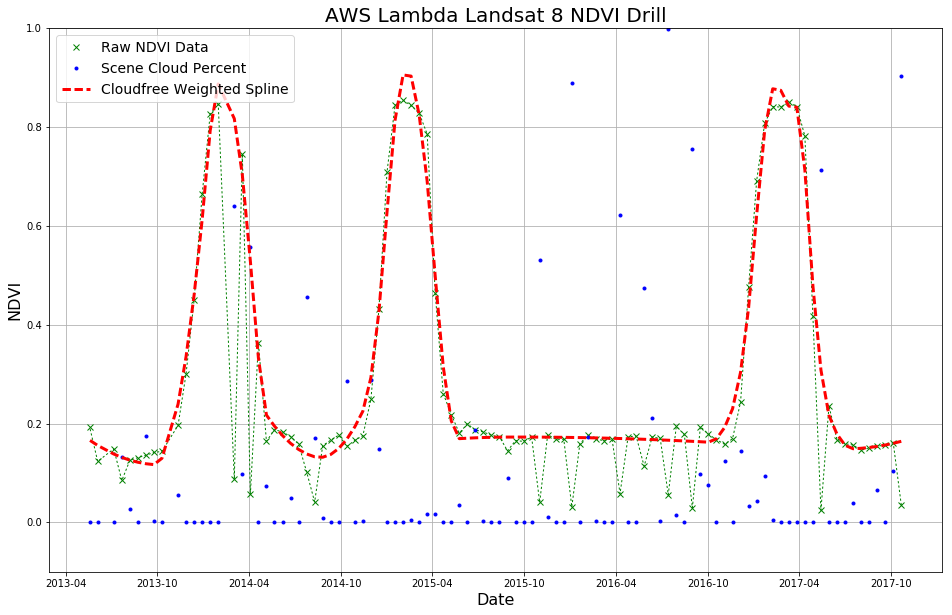

In [46]:
%%time

# The location of the point of interest
lonLat = '147.870599,-28.744617'


# Call the api to retrieve the scenes available under the point of interest
scenes = getSceneList(lonLat)

# Set up a pywren executor and map the NDVI retrieval across all the available scenes
pwex = pywren.default_executor()
timeSeries = pywren.get_all_results(pwex.map(getNDVI, scenes))

# Extract the data trom the list of results
timeStamps = [datetime.datetime.strptime(obs['date'],'%Y-%m-%d') for obs in timeSeries if 'date' in obs]
ndviSeries = [obs['ndvi'] for obs in timeSeries if 'ndvi' in obs]
cloudSeries = [obs['cloud']/100 for obs in timeSeries if 'cloud' in obs]

# Create a time variable as the x axis to fit the observations
# First we convert to seconds
timeSecs = numpy.array([(obsTime-datetime.datetime(1970,1,1)).total_seconds() for obsTime in timeStamps])
# And then normalise from 0 to 1 to avoid any numerical issues in the fitting
fitTime = ((timeSecs-numpy.min(timeSecs))/(numpy.max(timeSecs)-numpy.min(timeSecs)))

# Smooth the data by fitting a spline weighted by cloud amount
smoothedNDVI=UnivariateSpline(
    fitTime[numpy.argsort(fitTime)],
    numpy.array(ndviSeries)[numpy.argsort(fitTime)],
    w=(1.0-numpy.array(cloudSeries)[numpy.argsort(fitTime)])**2.0,
    k=2,
    s=0.1)(fitTime)


# Setup the figure and plot the data, fit and cloud amount
fig = plt.figure(figsize=(16,10))
plt.plot(timeStamps,ndviSeries, 'gx',label='Raw NDVI Data')
plt.plot(timeStamps,ndviSeries, 'g:', linewidth=1)
plt.plot(timeStamps,cloudSeries, 'b.', linewidth=1,label='Scene Cloud Percent')
plt.plot(timeStamps,smoothedNDVI, 'r--', linewidth=3,label='Cloudfree Weighted Spline')
plt.xlabel('Date', fontsize=16)
plt.ylabel('NDVI', fontsize=16)
plt.title('AWS Lambda Landsat 8 NDVI Drill', fontsize=20)
plt.grid(True)
plt.ylim([-.1,1.0])
plt.legend(fontsize=14)
#plt.savefig('lambdaNDVI.png', bbox_inches='tight')

### Run the code over another location
This is the middle of a rice paddy next to [where I used to live in Nepal](https://goo.gl/maps/FU8TGtLH7tr). It's pretty cloudy which makes the time series and then spline fitting pretty messy.

CPU times: user 22.9 s, sys: 9.68 s, total: 32.6 s
Wall time: 1min 28s


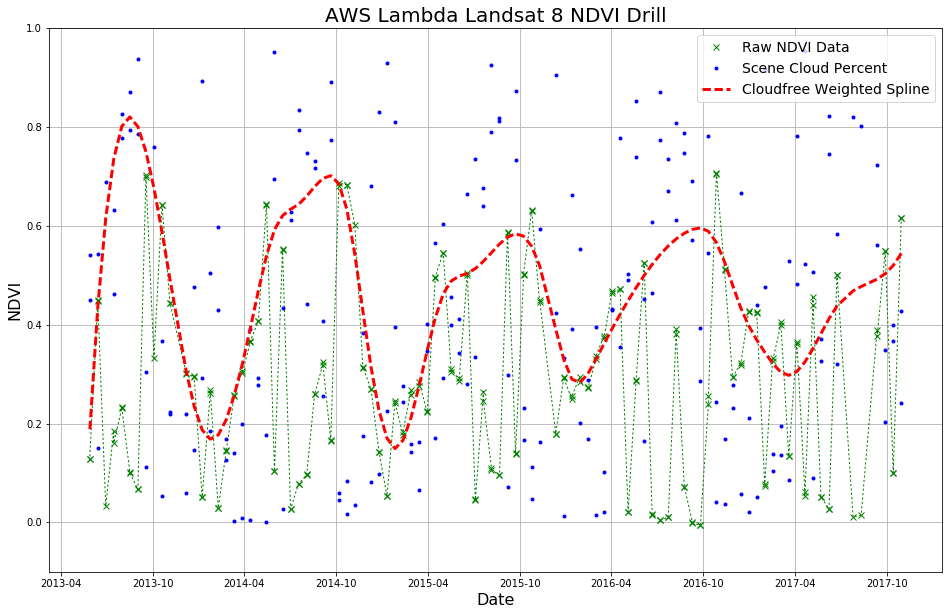

In [45]:
%%time

# The location of the point of interest
lonLat = '87.996185,26.680658'

# Call the api to retrieve the scenes available under the point of interest
scenes = getSceneList(lonLat)

# Set up a pywren executor and map the NDVI retrieval across all the available scenes
pwex = pywren.default_executor()
timeSeries = pywren.get_all_results(pwex.map(getNDVI, scenes))

# Extract the data trom the list of results
timeStamps = [datetime.datetime.strptime(obs['date'],'%Y-%m-%d') for obs in timeSeries if 'date' in obs]
ndviSeries = [obs['ndvi'] for obs in timeSeries if 'ndvi' in obs]
cloudSeries = [obs['cloud']/100 for obs in timeSeries if 'cloud' in obs]

# Create a time variable as the x axis to fit the observations
# First we convert to seconds
timeSecs = numpy.array([(obsTime-datetime.datetime(1970,1,1)).total_seconds() for obsTime in timeStamps])
# And then normalise from 0 to 1 to avoid any numerical issues in the fitting
fitTime = ((timeSecs-numpy.min(timeSecs))/(numpy.max(timeSecs)-numpy.min(timeSecs)))

# Smooth the data by fitting a spline weighted by cloud amount
# Note we change the parameters a little in this example to account for the very cloudey environment
smoothedNDVI=UnivariateSpline(
    fitTime[numpy.argsort(fitTime)],
    numpy.array(ndviSeries)[numpy.argsort(fitTime)],
    w=(1.0-numpy.array(cloudSeries)[numpy.argsort(fitTime)])**4.0,
    k=3,
    s=0.2)(fitTime)


# Setup the figure and plot the data, fit and cloud amount
fig = plt.figure(figsize=(16,10))
plt.plot(timeStamps,ndviSeries, 'gx',label='Raw NDVI Data')
plt.plot(timeStamps,ndviSeries, 'g:', linewidth=1)
plt.plot(timeStamps,cloudSeries, 'b.', linewidth=1,label='Scene Cloud Percent')
plt.plot(timeStamps,smoothedNDVI, 'r--', linewidth=3,label='Cloudfree Weighted Spline')
plt.xlabel('Date', fontsize=16)
plt.ylabel('NDVI', fontsize=16)
plt.title('AWS Lambda Landsat 8 NDVI Drill', fontsize=20)
plt.grid(True)
plt.ylim([-.1,1.0])
plt.legend(fontsize=14)
#plt.savefig('lambdaNDVI.png', bbox_inches='tight')